Realiza el mejor pronóstico que puedas para el tipo de cambio diario pesos-dólar al
31 de mayo de 2022, utilizando los datos disponibles hasta el 30 de noviembre de
2021.
Es decir tu modelo final no puede incluir observaciones de variables posteriores al 30
de noviembre de 2021.
Los datos que puedes utilizar los dejamos a tu consideración siempre y cuando sean
datos abiertos. Se considera un plus utilizar más de una fuente de datos. La
metodología y modelo también son tierra libre para tu creatividad.
En los slides de la presentación debes de incluir:
- Tus fuentes de datos y explicar la elección de las mismas.
- Los issues que encontraste con la limpieza de los mismos.
- Responder a la pregunta: ¿usarás toda la data?
- En caso de afirmativo o negativo, explica tu elección con argumentos
estadísticos, computacionales, econométricos o los que consideres
suficientemente sólidos en el contexto del sector financiero.

- Los resultados de tu modelo para el intervalo completo, con sus intervalos de
confianza.
- La justificación de la elección de tu modelo, incluyendo las respuestas a qué
métrica utilizaste para medir el error y en cuántos conjuntos separaste tu
dataset inicial.
- La interpretación de tu modelo, e.g. Si elegiste un VEC, ¿cómo se deben
interpretar los coeficientes?
- Las conclusiones, las cuales deben incluir al menos, las respuestas a las
siguientes preguntas:

a. ¿Para qué es útil este pronóstico en el contexto de la economía
mexicana?
b. ¿Para qué es útil este pronóstico para GFB?
c. ¿Qué otros usos le podrías dar a tu pronóstico?

In [1]:
# Instalación de statsmodel en su última versión
!pip install statsmodels --upgrade

In [2]:
# Importación de librerias
import pandas as pd
import  numpy as np

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Tipo de cambio FIX
#https://www.banxico.org.mx/SieInternet/consultarDirectorioInternetAction.do?sector=6&accion=consultarCuadro&idCuadro=CF102&locale=es
FIX = pd.read_excel("USD_MXN FIX.xlsx",skiprows = 17)
FIX

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Fecha,SF43787
0,2020-11-30,20.0750
1,2020-12-01,20.0330
2,2020-12-02,20.0320
3,2020-12-03,19.9030
4,2020-12-04,19.7680
...,...,...
247,2021-11-23,21.1585
248,2021-11-24,21.4730
249,2021-11-25,21.5270
250,2021-11-26,21.7800


In [4]:
# TIIE
#https://www.banxico.org.mx/SieInternet/consultarDirectorioInternetAction.do?sector=18&accion=consultarCuadro&idCuadro=CF101&locale=es
TIIE = pd.read_excel("TIIE.xlsx",skiprows = 17,)
TIIE

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Fecha,SF331451
0,2020-11-30,4.42
1,2020-12-01,4.35
2,2020-12-02,4.30
3,2020-12-03,4.24
4,2020-12-04,4.23
...,...,...
247,2021-11-23,4.98
248,2021-11-24,4.99
249,2021-11-25,4.98
250,2021-11-26,4.97


In [5]:
#Join TC con TIIE
merge1 = pd.merge(left = FIX, right=TIIE, left_on="Fecha", right_on="Fecha", how="inner")
merge1

,Fecha,SF43787,SF331451
0,2020-11-30,20.0750,4.42
1,2020-12-01,20.0330,4.35
2,2020-12-02,20.0320,4.30
3,2020-12-03,19.9030,4.24
4,2020-12-04,19.7680,4.23
...,...,...,...
247,2021-11-23,21.1585,4.98
248,2021-11-24,21.4730,4.99
249,2021-11-25,21.5270,4.98
250,2021-11-26,21.7800,4.97


In [6]:
#Reservas Internacionales
#https://www.banxico.org.mx/SieInternet/consultarDirectorioInternetAction.do?sector=4&accion=consultarCuadro&idCuadro=CF106&locale=es
RI = pd.read_excel("ReservasInternacionales.xlsx",skiprows = 17)
RI

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Fecha,SF43707
0,2020-12-04,194359.1
1,2020-12-11,195340.6
2,2020-12-18,195441.2
3,2020-12-24,195479.1
4,2020-12-31,195667.2
5,2021-01-08,195517.8
6,2021-01-15,195438.1
7,2021-01-22,195957.2
8,2021-01-29,195946.1
9,2021-02-05,195726.3


In [7]:
#Join de TC, TIIE y RI
merge2 = pd.merge(left = merge1, right=RI, left_on="Fecha", right_on="Fecha", how="left")
merge2 = merge2.fillna(method="bfill")
merge2 = merge2.fillna(method="ffill")
merge2

,Fecha,SF43787,SF331451,SF43707
0,2020-11-30,20.0750,4.42,194359.1
1,2020-12-01,20.0330,4.35,194359.1
2,2020-12-02,20.0320,4.30,194359.1
3,2020-12-03,19.9030,4.24,194359.1
4,2020-12-04,19.7680,4.23,194359.1
...,...,...,...,...
247,2021-11-23,21.1585,4.98,199310.1
248,2021-11-24,21.4730,4.99,199310.1
249,2021-11-25,21.5270,4.98,199310.1
250,2021-11-26,21.7800,4.97,199310.1


In [8]:
# Federal Funds
#https://www.federalreserve.gov/datadownload/Download.aspx?rel=H15&series=c5025f4bbbed155a6f17c587772ed69e&filetype=csv&label=include&layout=seriescolumn&from=11/30/2020&to=11/30/2021
FF = pd.read_csv("FederalFunds.csv", skiprows=5)
FF

,Time Period,RIFSPFF_N.D
0,2020-11-30,0.09
1,2020-12-01,0.09
2,2020-12-02,0.09
3,2020-12-03,0.09
4,2020-12-04,0.09
...,...,...
361,2021-11-26,0.08
362,2021-11-27,0.08
363,2021-11-28,0.08
364,2021-11-29,0.08


In [9]:
# Join TC, TIIE, RI, FF
FF['Time Period'] = pd.to_datetime(FF['Time Period'], format = '%Y-%m-%d')
merge3 = pd.merge(left = merge2, right=FF, left_on="Fecha", right_on="Time Period", how="left")

In [10]:
# Cambio de indice (se evita la hora, minuto, segundo)

merge3['Fecha'] = merge3['Fecha'].dt.strftime('%Y/%m/%d')
merge3.index = merge3.Fecha
#merge2.drop(["Fecha"],axis=0)
merge3

,Fecha,SF43787,SF331451,SF43707,Time Period,RIFSPFF_N.D
Fecha,,,,,,
2020/11/30,2020/11/30,20.0750,4.42,194359.1,2020-11-30,0.09
2020/12/01,2020/12/01,20.0330,4.35,194359.1,2020-12-01,0.09
2020/12/02,2020/12/02,20.0320,4.30,194359.1,2020-12-02,0.09
2020/12/03,2020/12/03,19.9030,4.24,194359.1,2020-12-03,0.09
2020/12/04,2020/12/04,19.7680,4.23,194359.1,2020-12-04,0.09
...,...,...,...,...,...,...
2021/11/23,2021/11/23,21.1585,4.98,199310.1,2021-11-23,0.08
2021/11/24,2021/11/24,21.4730,4.99,199310.1,2021-11-24,0.08
2021/11/25,2021/11/25,21.5270,4.98,199310.1,2021-11-25,0.08


In [11]:
# Cambio de nombres de columnas

df_m = merge3
df_m = df_m[["Fecha","SF43787",	"SF331451",	"SF43707", "RIFSPFF_N.D"]]
df_m.columns = ["Fecha1","TC","TIIE","RI","FF"]
df_m

,Fecha1,TC,TIIE,RI,FF
Fecha,,,,,
2020/11/30,2020/11/30,20.0750,4.42,194359.1,0.09
2020/12/01,2020/12/01,20.0330,4.35,194359.1,0.09
2020/12/02,2020/12/02,20.0320,4.30,194359.1,0.09
2020/12/03,2020/12/03,19.9030,4.24,194359.1,0.09
2020/12/04,2020/12/04,19.7680,4.23,194359.1,0.09
...,...,...,...,...,...
2021/11/23,2021/11/23,21.1585,4.98,199310.1,0.08
2021/11/24,2021/11/24,21.4730,4.99,199310.1,0.08
2021/11/25,2021/11/25,21.5270,4.98,199310.1,0.08


In [12]:
# 

df_m.index = pd.to_datetime(df_m.index, format="%Y/%m/%d")
df_m

,Fecha1,TC,TIIE,RI,FF
Fecha,,,,,
2020-11-30,2020/11/30,20.0750,4.42,194359.1,0.09
2020-12-01,2020/12/01,20.0330,4.35,194359.1,0.09
2020-12-02,2020/12/02,20.0320,4.30,194359.1,0.09
2020-12-03,2020/12/03,19.9030,4.24,194359.1,0.09
2020-12-04,2020/12/04,19.7680,4.23,194359.1,0.09
...,...,...,...,...,...
2021-11-23,2021/11/23,21.1585,4.98,199310.1,0.08
2021-11-24,2021/11/24,21.4730,4.99,199310.1,0.08
2021-11-25,2021/11/25,21.5270,4.98,199310.1,0.08


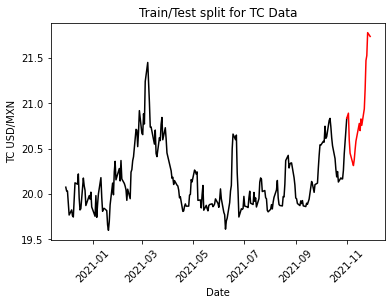

In [13]:
# Separación de datos en train/test
train = df_m[df_m.index <= "2021-11-01"]
test = df_m[df_m.index >= "2021-11-01"]

# Gráfico de los datos para TC
plt.plot(train["TC"], color = "black")
plt.plot(test["TC"], color = "red")
plt.ylabel('TC USD/MXN')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for TC Data")
plt.show()

In [14]:
# Variable para modelos ARIMA y SARIMA
y=train["TC"]

## SARIMA

In [15]:
# Grid Search para modelo SARIMA

list_RMSE=[]
list_MAE=[]
list_param=[]

p = range(1,6,1)
i = range(1,6,1)
d = range(1,6,1)

#a = range(1,3,1)
#b = range(1,3,1)
#c = range(1,3,1)
#d = range(1,3,1)

for p1 in p:
  for i1 in i:
    for d1 in d:

      #SARIMAXmodel = SARIMAX(y, order = (p1, i1, d1), seasonal_order=(2,2,2,14))
      SARIMAXmodel = SARIMAX(y, order = (p1, i1, d1), seasonal_order=(2,2,2,12))
      SARIMAXmodel = SARIMAXmodel.fit()

      y_pred = SARIMAXmodel.get_forecast(len(test.index))
      y_pred_df = y_pred.conf_int(alpha = 0.05) 
      y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
      y_pred_df.index = test.index
      y_pred_out = y_pred_df["Predictions"] 

      arima_rmse = np.sqrt(mean_squared_error(test["TC"].values, y_pred_df["Predictions"]))
      arima_mae = mean_absolute_error(test["TC"].values, y_pred_df["Predictions"])
      #print("RMSE: ",arima_rmse)
      list_RMSE.append(arima_rmse)
      list_MAE.append(arima_mae)
      list_param.append([p1,i1,d1])

df_grid = pd.DataFrame([list_param,list_RMSE,list_MAE])
df_grid

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No suppo

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,"[1, 1, 1]","[1, 1, 2]","[1, 1, 3]","[1, 1, 4]","[1, 1, 5]","[1, 2, 1]","[1, 2, 2]","[1, 2, 3]","[1, 2, 4]","[1, 2, 5]",...,"[5, 4, 1]","[5, 4, 2]","[5, 4, 3]","[5, 4, 4]","[5, 4, 5]","[5, 5, 1]","[5, 5, 2]","[5, 5, 3]","[5, 5, 4]","[5, 5, 5]"
1,0.358246,0.357001,0.389586,0.425251,0.350823,0.332131,0.330875,0.330763,0.338502,0.330098,...,13.123364,14.48771,2.99535,2.810383,4.643341,48.732189,21.552271,18.896824,21.727468,26.694652
2,0.287768,0.292483,0.280392,0.28606,0.282506,0.290602,0.288537,0.288075,0.304843,0.292697,...,10.406544,11.449847,2.591549,2.450517,3.89491,35.652197,16.007481,14.419141,16.503463,20.009723


In [16]:
# Ordenar mejores hiperparámetros por RMSE

df_grid = df_grid.T
df_grid.columns=["p,i,q","RMSE","MAE"]
df_grid.sort_values("RMSE").head()

,"p,i,q",RMSE,MAE
19,"[1, 4, 5]",0.324143,0.294918
33,"[2, 2, 4]",0.324229,0.279282
32,"[2, 2, 3]",0.326895,0.28664
34,"[2, 2, 5]",0.327198,0.289366
81,"[4, 2, 2]",0.328015,0.288821


In [17]:
# Ordenar mejores hiperparámetros por MAE

df_grid.sort_values("MAE").head()

,"p,i,q",RMSE,MAE
51,"[3, 1, 2]",0.346937,0.278119
26,"[2, 1, 2]",0.338969,0.278174
33,"[2, 2, 4]",0.324229,0.279282
27,"[2, 1, 3]",0.404875,0.279616
2,"[1, 1, 3]",0.389586,0.280392


In [18]:
# Train de mejor modelo SARIMA con RMSE 

SARIMAXmodel = SARIMAX(y, order = (4, 2, 2), seasonal_order=(2,2,2,12)) # RMSE
SARIMAXmodel = SARIMAXmodel.fit()

# Prediccion de mejor modelo SARIMA con RMSE 
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions_RMSE"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out1 = y_pred_df["Predictions_RMSE"]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


In [19]:
# Train de mejor modelo SARIMA con MAE 
SARIMAXmodel = SARIMAX(y, order = (3, 1, 2), seasonal_order=(2,2,2,12)) # MAE
SARIMAXmodel = SARIMAXmodel.fit()

# Prediccion de mejor modelo SARIMA con MAE 
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions_MAE"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out2 = y_pred_df["Predictions_MAE"]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No suppo

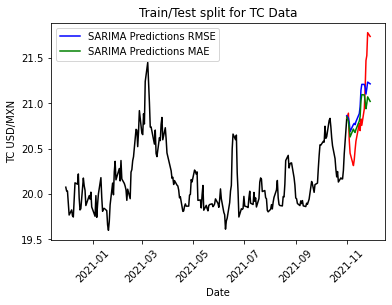

In [20]:
# Visualización mejores modelos SARIMA

plt.plot(train["TC"], color = "black")
plt.plot(test["TC"], color = "red")
plt.plot(y_pred_out1, color='Blue', label = 'SARIMA Predictions RMSE')
plt.plot(y_pred_out2, color='Green', label = 'SARIMA Predictions MAE')

plt.ylabel('TC USD/MXN')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for TC Data")
plt.legend()
plt.show()

## ARIMA Grid

In [21]:
# Grid Search para modelo ARIMA

list_RMSE=[]
list_MAE=[]
list_param=[]

p = range(1,15,1)
i = range(1,4,1)
d = range(1,15,1)

for p1 in p:
  for i1 in i:
    for d1 in d:
      ARIMAmodel = ARIMA(y, order = (p1, i1, d1))
      ARIMAmodel = ARIMAmodel.fit()

      y_pred = ARIMAmodel.get_forecast(len(test.index))
      y_pred_df = y_pred.conf_int(alpha = 0.05) 
      y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
      y_pred_df.index = test.index
      y_pred_out = y_pred_df["Predictions"] 

      arima_rmse = np.sqrt(mean_squared_error(test["TC"].values, y_pred_df["Predictions"]))
      arima_mae = mean_absolute_error(test["TC"].values, y_pred_df["Predictions"])
      #print("RMSE: ",arima_rmse)
      list_RMSE.append(arima_rmse)
      list_MAE.append(arima_mae)
      list_param.append([p1,i1,d1])

df_grid = pd.DataFrame([list_param,list_RMSE,list_MAE])
df_grid

Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/

,0,1,2,3,4,5,6,7,8,9,...,578,579,580,581,582,583,584,585,586,587
0,"[1, 1, 1]","[1, 1, 2]","[1, 1, 3]","[1, 1, 4]","[1, 1, 5]","[1, 1, 6]","[1, 1, 7]","[1, 1, 8]","[1, 1, 9]","[1, 1, 10]",...,"[14, 3, 5]","[14, 3, 6]","[14, 3, 7]","[14, 3, 8]","[14, 3, 9]","[14, 3, 10]","[14, 3, 11]","[14, 3, 12]","[14, 3, 13]","[14, 3, 14]"
1,0.448584,0.448643,0.69088,0.56851,0.5723,0.550588,0.548945,0.54357,0.548234,0.532979,...,0.365158,0.881468,0.383825,0.40645,0.371872,0.376177,0.39973,0.379843,0.375078,0.378749
2,0.355389,0.360728,0.501971,0.417941,0.420332,0.408932,0.408456,0.400406,0.406079,0.387938,...,0.282036,0.820996,0.29658,0.3042,0.325762,0.324165,0.310038,0.337604,0.325554,0.306177


In [22]:
# Ordenamiento por RMSE

df_grid = df_grid.T
df_grid.columns=["p,i,q","RMSE","MAE"]
df_grid.sort_values("RMSE").head()

,"p,i,q",RMSE,MAE
493,"[12, 3, 4]",0.30067,0.261739
535,"[13, 3, 4]",0.307893,0.274936
574,"[14, 3, 1]",0.332101,0.293793
325,"[8, 3, 4]",0.354541,0.321219
536,"[13, 3, 5]",0.355441,0.271759


In [23]:
# Ordenamiento por MAE
df_grid.sort_values("MAE").head()

,"p,i,q",RMSE,MAE
493,"[12, 3, 4]",0.30067,0.261739
536,"[13, 3, 5]",0.355441,0.271759
535,"[13, 3, 4]",0.307893,0.274936
578,"[14, 3, 5]",0.365158,0.282036
451,"[11, 3, 4]",0.371499,0.285684


In [24]:
# Train de mejor modelo ARIMA con RMSE 
ARIMAmodel = ARIMA(y, order = (12, 3, 4)) #RMSE
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions_RMSE"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out1 = y_pred_df["Predictions_RMSE"] 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.

In [25]:
# Train de mejor modelo SARIMA con MAE 
ARIMAmodel = ARIMA(y, order = (13, 3, 5)) #MAE
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions_MAE"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out2 = y_pred_df["Predictions_MAE"] 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/l

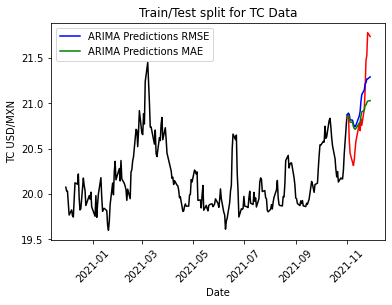

In [26]:
# Visualización de mejor modelo ARIMA 
plt.plot(train["TC"], color = "black")
plt.plot(test["TC"], color = "red")
plt.plot(y_pred_out1, color='Blue', label = 'ARIMA Predictions RMSE')
plt.plot(y_pred_out2, color='Green', label = 'ARIMA Predictions MAE')

plt.ylabel('TC USD/MXN')
plt.xlabel('Date')
plt.xticks(rotation=45)

plt.title("Train/Test split for TC Data")
plt.legend()
plt.show()

## VARMA

In [27]:
# Preparación de datos para modelo VARMA (train)

train1=train
#train1["dif TI"] = train1["TIIE"] - train1["FF"]
train1 = train1.drop("Fecha1",axis=1)
train1

,TC,TIIE,RI,FF
Fecha,,,,
2020-11-30,20.0750,4.42,194359.1,0.09
2020-12-01,20.0330,4.35,194359.1,0.09
2020-12-02,20.0320,4.30,194359.1,0.09
2020-12-03,19.9030,4.24,194359.1,0.09
2020-12-04,19.7680,4.23,194359.1,0.09
...,...,...,...,...
2021-10-26,20.1665,4.77,198850.4,0.08
2021-10-27,20.1665,4.77,198850.4,0.08
2021-10-28,20.2605,4.87,198850.4,0.08


In [28]:
# Preparación de datos para modelo VARMA (train)

test1=test
#test1["dif TI"] = test1["TIIE"] - test1["FF"]
test1 = test1.drop("Fecha1",axis=1)
test1

,TC,TIIE,RI,FF
Fecha,,,,
2021-11-01,20.8345,4.88,198919.7,0.08
2021-11-03,20.8915,4.92,198919.7,0.08
2021-11-04,20.5940,4.77,198919.7,0.08
2021-11-05,20.4505,4.77,198919.7,0.08
2021-11-08,20.3465,4.77,198788.1,0.08
2021-11-09,20.3135,4.80,198788.1,0.08
2021-11-10,20.3800,4.79,198788.1,0.08
2021-11-11,20.4885,4.77,198788.1,0.08
2021-11-12,20.5825,5.02,198788.1,0.08


In [29]:
# GridSearch modelo VARMA

list_RMSE=[]
list_MAE=[]
list_param=[]

p = range(1,3,1)
d = range(1,3,1)
t_params = ['n','c','t','ct']

for p1 in p:
  for d1 in d:
    for t1 in t_params:
      exog = train1['FF']
      #mod = sm.tsa.VARMAX(train1[["TC","RI"]], order=(p1,d1), trend=t1, exog=exog, enforce_stationary=True)
      mod = sm.tsa.VARMAX(train1[["TC","RI"]], order=(p1,d1), trend=t1, enforce_stationary=True)
      res = mod.fit(maxiter=6000, disp=False)

      exog1 = test1['FF']
      #yhat = res.forecast(steps=len(test1.index),exog=exog1,enforce_stationary=True)
      yhat = res.forecast(steps=len(test1.index))
      yhat.index = test1.index
      #yhat["TC_Real"] = test[1:]["TC"]
      yhat["TC_Real"] = test[0:]["TC"]
      yhat

      varmax_rmse = np.sqrt(mean_squared_error(yhat["TC_Real"].values, yhat["TC"]))
      varmax_mae = mean_absolute_error(yhat["TC_Real"].values, yhat["TC"])
      #print("RMSE: ",arima_rmse)
      list_RMSE.append(varmax_rmse)
      list_MAE.append(varmax_mae)
      list_param.append([p1,d1,t1])

df_grid = pd.DataFrame([list_param,list_RMSE,list_MAE])
df_grid

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespac

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,"[1, 1, n]","[1, 1, c]","[1, 1, t]","[1, 1, ct]","[1, 2, n]","[1, 2, c]","[1, 2, t]","[1, 2, ct]","[2, 1, n]","[2, 1, c]","[2, 1, t]","[2, 1, ct]","[2, 2, n]","[2, 2, c]","[2, 2, t]","[2, 2, ct]"
1,0.56913,0.66364,0.748106,0.615793,0.611248,0.665899,0.709579,0.609629,0.626475,0.678568,1.218323,0.630727,0.58697,0.677929,0.825666,0.620122
2,0.415042,0.481525,0.69695,0.447938,0.449343,0.485161,0.657535,0.445562,0.460195,0.491139,1.157408,0.45834,0.449753,0.493947,0.7747,0.452402


In [30]:
# Ordenamiento por RMSE

df_grid = df_grid.T
df_grid.columns=["p,q,t","RMSE","MAE"]
df_grid.sort_values("RMSE").head()

,"p,q,t",RMSE,MAE
0,"[1, 1, n]",0.56913,0.415042
12,"[2, 2, n]",0.58697,0.449753
7,"[1, 2, ct]",0.609629,0.445562
4,"[1, 2, n]",0.611248,0.449343
3,"[1, 1, ct]",0.615793,0.447938


In [31]:
#Ordenamiento por MAE

df_grid.sort_values("MAE").head()

,"p,q,t",RMSE,MAE
0,"[1, 1, n]",0.56913,0.415042
7,"[1, 2, ct]",0.609629,0.445562
3,"[1, 1, ct]",0.615793,0.447938
4,"[1, 2, n]",0.611248,0.449343
12,"[2, 2, n]",0.58697,0.449753


In [32]:
# Ajuste de modelo VARMA (RMSE)

exog = train1['FF']
#mod = sm.tsa.VARMAX(train1[["TC","RI"]], order=(1,2), trend='c', exog=exog, enforce_stationary=True)
mod = sm.tsa.VARMAX(train1[["TC","RI"]], order=(1,1), trend='n', enforce_stationary=True) #RMSE
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                           Statespace Model Results                           
Dep. Variable:           ['TC', 'RI']   No. Observations:                  234
Model:                     VARMA(1,1)   Log Likelihood               -2076.377
Date:                Tue, 15 Mar 2022   AIC                           4174.754
Time:                        04:07:36   BIC                           4212.762
Sample:                             0   HQIC                          4190.079
                                - 234                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):           153.27, 0.59   Jarque-Bera (JB):      43.64, 17735.95
Prob(Q):                        0.00, 0.44   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.10, 4.64   Skew:                      -0.12, 3.94
Prob(H) (two-sided):            0.68, 0.00   Kurtosis:                  5.10, 44.92
                           Resul

In [33]:
# Predicción de modelo VARMA (RMSE)

exog1 = test1['FF']
#yhat1 = res.forecast(steps=len(test1.index),exog=exog1, enforce_stationary=True)
yhat1 = res.forecast(steps=len(test1.index))
yhat1.index = test1.index
#yhat1["TC_Real_RMSE"] = test[1:]["TC"]
yhat1["TC_Real_RMSE"] = test[0:]["TC"]
yhat1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


,TC,RI,TC_Real_RMSE
Fecha,,,
2021-11-01,20.553174,199783.876148,20.8345
2021-11-03,20.550059,199764.342536,20.8915
2021-11-04,20.548882,199742.161601,20.5940
2021-11-05,20.545769,199722.631336,20.4505
2021-11-08,20.544591,199700.455764,20.3465
2021-11-09,20.541479,199680.928846,20.3135
2021-11-10,20.540301,199658.758635,20.3800
2021-11-11,20.537190,199639.235064,20.4885
2021-11-12,20.536012,199617.070212,20.5825


In [34]:
# Ajuste modelo VARMA (MAE)

exog = train1['FF']
#mod = sm.tsa.VARMAX(train1[["TC","TIIE","RI"]], order=(1,2), trend='c', exog=exog, enforce_stationary=True)
mod = sm.tsa.VARMAX(train1[["TC","RI"]], order=(1,2), trend='ct',enforce_stationary=True ) #MAE
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                           Statespace Model Results                           
Dep. Variable:           ['TC', 'RI']   No. Observations:                  234
Model:                     VARMA(1,2)   Log Likelihood               -1784.496
                          + intercept   AIC                           3606.991
Date:                Tue, 15 Mar 2022   BIC                           3672.642
Time:                        04:07:37   HQIC                          3633.462
Sample:                             0                                         
                                - 234                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             0.00, 0.00   Jarque-Bera (JB):     14.32, 164466.43
Prob(Q):                        0.97, 1.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):        0.36, 36.68   Skew:                       0.42, 7.91
Prob(H) (two-sided):            0.00,

In [35]:
# Predicción de modelo VARMA (MAE)

exog1 = test1['FF']
#yhat2 = res.forecast(steps=len(test1.index),exog=exog1, enforce_stationary=True)
yhat2 = res.forecast(steps=len(test1.index))
yhat2.index = test1.index
#yhat2["TC_Real_MAE"] = test[1:]["TC"]
yhat2["TC_Real_MAE"] = test[0:]["TC"]
yhat2

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


,TC,RI,TC_Real_MAE
Fecha,,,
2021-11-01,20.834128,199258.875028,20.8345
2021-11-03,20.827843,199352.581078,20.8915
2021-11-04,20.786077,199407.637341,20.5940
2021-11-05,20.747483,199448.386324,20.4505
2021-11-08,20.711837,199476.718953,20.3465
2021-11-09,20.678929,199494.328608,20.3135
2021-11-10,20.648565,199502.729493,20.3800
2021-11-11,20.620561,199503.273427,20.4885
2021-11-12,20.594749,199497.165173,20.5825


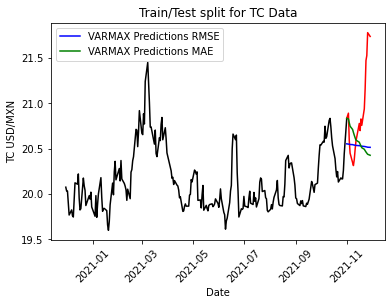

In [36]:
# Visualización modelo VARMA

plt.plot(train1["TC"], color = "black")
plt.plot(yhat1["TC_Real_RMSE"], color = "red")
plt.plot(yhat1["TC"], color='Blue', label = 'VARMAX Predictions RMSE')
plt.plot(yhat2["TC"], color='Green', label = 'VARMAX Predictions MAE')

plt.ylabel('TC USD/MXN')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for TC Data")
plt.legend()
plt.show()

## VARMA Mensual

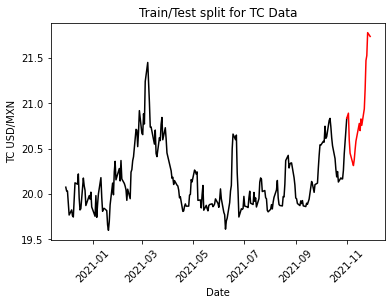

In [37]:
# Preparacion de datos mensuales

trainm = df_m[df_m.index <= "2021-09-30"]
testm = df_m[df_m.index >= "2021-10-01"]
#train

plt.plot(train["TC"], color = "black")
plt.plot(test["TC"], color = "red")
plt.ylabel('TC USD/MXN')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for TC Data")
plt.show()

In [38]:
# Agrupamiento mensual (train)

trainM = trainm.resample('M').mean()
trainM

,TC,TIIE,RI,FF
Fecha,,,,
2020-11-30,20.075000,4.420000,194359.100000,0.090000
2020-12-31,19.956477,4.293182,195269.572727,0.090000
2021-01-31,19.925800,4.302500,195714.800000,0.085500
2021-02-28,20.314421,4.114737,195597.931579,0.075789
2021-03-31,20.759750,4.016364,194949.800000,0.069545
2021-04-30,20.020200,4.014000,195222.400000,0.068500
2021-05-31,19.963286,4.036190,194542.304762,0.059048
2021-06-30,20.016364,4.043636,193183.740909,0.077273
2021-07-31,19.958136,4.275455,193242.400000,0.098636


In [39]:
# Agrupamiento mensual (test)

testM = testm.resample('M').mean()
testM

,TC,TIIE,RI,FF
Fecha,,,,
2021-10-31,20.460452,4.803810,198598.223810,0.079524
2021-11-30,20.871579,4.911053,198938.057895,0.080000


In [40]:
# GridSearch modelo VARMA Mensual

list_RMSE=[]
list_MAE=[]
list_param=[]

p = range(1,3,1)
d = range(1,3,1)
t_params = ['n','c','t','ct']

for p1 in p:
  for d1 in d:
    for t1 in t_params:
      exog = train1['FF']
      #mod = sm.tsa.VARMAX(train1[["TC","RI"]], order=(p1,d1), trend=t1, exog=exog, enforce_stationary=True)
      #mod = sm.tsa.VARMAX(train1[["TC","RI"]], order=(p1,d1), trend=t1, enforce_stationary=True)
      mod = sm.tsa.VARMAX(trainM[["TC","RI"]], order=(p1,d1), trend=t1, enforce_stationary=True) #MES
      res = mod.fit(maxiter=6000, disp=False)

      exog1 = test1['FF']
      #yhat = res.forecast(steps=len(test1.index),exog=exog1,enforce_stationary=True)
      #yhat = res.forecast(steps=len(test1.index))
      yhat = res.forecast(steps=len(testM.index))
      yhat.index = testM.index
      #yhat["TC_Real"] = test[1:]["TC"]
      yhat["TC_Real"] = testM[0:]["TC"]
      yhat

      varmax_rmse = np.sqrt(mean_squared_error(yhat["TC_Real"].values, yhat["TC"]))
      varmax_mae = mean_absolute_error(yhat["TC_Real"].values, yhat["TC"])
      #print("RMSE: ",arima_rmse)
      list_RMSE.append(varmax_rmse)
      list_MAE.append(varmax_mae)
      list_param.append([p1,d1,t1])

df_grid = pd.DataFrame([list_param,list_RMSE,list_MAE])
df_grid

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:396: UserWarnin

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,"[1, 1, n]","[1, 1, c]","[1, 1, t]","[1, 1, ct]","[1, 2, n]","[1, 2, c]","[1, 2, t]","[1, 2, ct]","[2, 1, n]","[2, 1, c]","[2, 1, t]","[2, 1, ct]","[2, 2, n]","[2, 2, c]","[2, 2, t]","[2, 2, ct]"
1,0.43518,0.406806,3.381379,0.492773,23.978587,0.311258,3.381379,0.463415,0.770372,0.483754,0.803445,0.511631,0.264391,0.232059,0.07004,0.301294
2,0.376536,0.358046,3.272601,0.448731,18.647205,0.256202,3.272601,0.418642,0.768533,0.446288,0.772951,0.477771,0.256371,0.213414,0.062283,0.222459


In [41]:
# Ordenamiento RMSE

df_grid = df_grid.T
df_grid.columns=["p,q,t","RMSE","MAE"]
df_grid.sort_values("RMSE").head()

,"p,q,t",RMSE,MAE
14,"[2, 2, t]",0.07004,0.062283
13,"[2, 2, c]",0.232059,0.213414
12,"[2, 2, n]",0.264391,0.256371
15,"[2, 2, ct]",0.301294,0.222459
5,"[1, 2, c]",0.311258,0.256202


In [42]:
# Ordenamiento MAE

df_grid.sort_values("MAE").head()

,"p,q,t",RMSE,MAE
14,"[2, 2, t]",0.07004,0.062283
13,"[2, 2, c]",0.232059,0.213414
15,"[2, 2, ct]",0.301294,0.222459
5,"[1, 2, c]",0.311258,0.256202
12,"[2, 2, n]",0.264391,0.256371


In [43]:
# Ajuste de modelo VARMA (RMSE) Mensuak

exog = train1['FF']
#mod = sm.tsa.VARMAX(train1[["TC","RI"]], order=(1,2), trend='c', exog=exog, enforce_stationary=True)
mod = sm.tsa.VARMAX(trainM[["TC","RI"]], order=(2,2), trend='t', enforce_stationary=True) #RMSE
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:396: UserWarning: Non-stationary starting moving-average parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting moving-average parameters'
/usr/local/lib/python3.7/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.20982e-18): result may not be accurate.
  x = solve(lhs, q.flatten())


                           Statespace Model Results                           
Dep. Variable:           ['TC', 'RI']   No. Observations:                   11
Model:                     VARMA(2,2)   Log Likelihood                -102.268
                          + intercept   AIC                            246.537
Date:                Tue, 15 Mar 2022   BIC                            254.892
Time:                        04:08:04   HQIC                           241.269
Sample:                    11-30-2020                                         
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             1.59, 0.01   Jarque-Bera (JB):           0.88, 0.54
Prob(Q):                        0.21, 0.91   Prob(JB):                   0.64, 0.76
Heteroskedasticity (H):         1.29, 2.49   Skew:                      -0.39, 0.44
Prob(H) (two-sided):            0.81,

In [44]:
# Predicción de modelo VARMA (RMSE) Mensual

exog1 = test1['FF']
#yhat2 = res.forecast(steps=len(test1.index),exog=exog1, enforce_stationary=True)
yhat1 = res.forecast(steps=len(testM.index))
yhat1.index = testM.index
#yhat2["TC_Real_MAE"] = test[1:]["TC"]
yhat1["TC_Real_RMSE"] = testM[0:]["TC"]
yhat1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


,TC,RI,TC_Real_RMSE
Fecha,,,
2021-10-31,20.490696,201681.329774,20.460452
2021-11-30,20.965901,204747.524598,20.871579


In [45]:
# Ajuste de modelo VARMA (MAE) Mensual

exog = train1['FF']
#mod = sm.tsa.VARMAX(train1[["TC","RI"]], order=(1,2), trend='c', exog=exog, enforce_stationary=True)
mod = sm.tsa.VARMAX(trainM[["TC","RI"]], order=(2,2), trend='c', enforce_stationary=True) #MAE
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                           Statespace Model Results                           
Dep. Variable:           ['TC', 'RI']   No. Observations:                   11
Model:                     VARMA(2,2)   Log Likelihood                 -89.134
                          + intercept   AIC                            220.268
Date:                Tue, 15 Mar 2022   BIC                            228.624
Time:                        04:08:07   HQIC                           215.001
Sample:                    11-30-2020                                         
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             0.01, 0.20   Jarque-Bera (JB):           3.31, 0.73
Prob(Q):                        0.93, 0.65   Prob(JB):                   0.19, 0.70
Heteroskedasticity (H):        1.20, 17.69   Skew:                       1.33, 0.60
Prob(H) (two-sided):            0.86,

In [46]:
# Predicción modelo VARMA (MAE) Mensual

exog1 = test1['FF']
#yhat2 = res.forecast(steps=len(test1.index),exog=exog1, enforce_stationary=True)
yhat2 = res.forecast(steps=len(testM.index))
yhat2.index = testM.index
#yhat2["TC_Real_MAE"] = test[1:]["TC"]
yhat2["TC_Real_MAE"] = testM[0:]["TC"]
yhat2

,TC,RI,TC_Real_MAE
Fecha,,,
2021-10-31,20.582730,196667.768583,20.460452
2021-11-30,20.567028,194174.190301,20.871579


In [47]:
# Unión de datos para visualización

result = trainM
result1 = pd.concat([result, testM], axis= 0)
result2 = pd.concat([result1, yhat1], axis= 1)
result2TC = result2["TC"]
result2TC.columns=["TC_Real", "TC_pred"]
result2TC

,TC_Real,TC_pred
Fecha,,
2020-11-30,20.075000,NaN
2020-12-31,19.956477,NaN
2021-01-31,19.925800,NaN
2021-02-28,20.314421,NaN
2021-03-31,20.759750,NaN
2021-04-30,20.020200,NaN
2021-05-31,19.963286,NaN
2021-06-30,20.016364,NaN
2021-07-31,19.958136,NaN


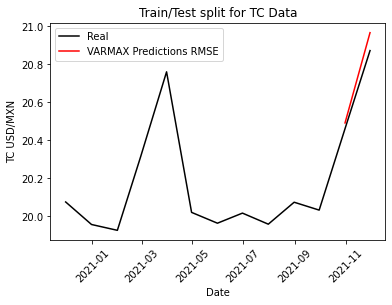

In [48]:
# Visualización de modelo VARMA mensual
plt.plot(result2TC["TC_Real"], color = "black", label = "Real")
plt.plot(result2TC["TC_pred"], color = "red", label = 'VARMAX Predictions RMSE')

plt.ylabel('TC USD/MXN')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for TC Data")
plt.legend()
plt.show()

## Resultado Final VARMA Mensual

In [49]:
#FIX 2022
#https://www.banxico.org.mx/SieInternet/consultarDirectorioInternetAction.do?sector=6&accion=consultarCuadro&idCuadro=CF102&locale=es

FIX_t = pd.read_excel("FIX_test.xlsx",skiprows = 17)
FIX_t

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Fecha,SF43718
0,2021-11-30,21.4453
1,2021-12-01,21.2710
2,2021-12-02,21.3033
3,2021-12-03,21.4177
4,2021-12-06,21.2047
...,...,...
68,2022-03-07,21.1947
69,2022-03-08,21.3775
70,2022-03-09,20.9677
71,2022-03-10,20.9743


In [50]:
#Reservas Internacionales 2022
#https://www.banxico.org.mx/SieInternet/consultarDirectorioInternetAction.do?sector=4&accion=consultarCuadro&idCuadro=CF106&locale=es

RI_t = pd.read_excel("RI_test.xlsx",skiprows = 17)
RI_t

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Fecha,SF43707
0,2021-12-03,199993.0
1,2021-12-10,201440.6
2,2021-12-17,202303.4
3,2021-12-24,202273.5
4,2021-12-31,202399.2
5,2022-01-07,201952.8
6,2022-01-14,202099.7
7,2022-01-21,201995.6
8,2022-01-28,201583.4
9,2022-02-04,201698.2


In [51]:
# Preparación de datos

merge4 = pd.merge(left = FIX_t, right=RI_t, left_on="Fecha", right_on="Fecha", how="left")
merge4['Fecha'] = merge4['Fecha'].dt.strftime('%Y/%m/%d')
merge4.index = merge4.Fecha
merge4.index = pd.to_datetime(merge4.index, format="%Y/%m/%d")
merge4 = merge4.fillna(method="bfill")
merge4 = merge4.fillna(method="ffill")
merge4.columns=["Fecha","TC","RI"]
merge4

,Fecha,TC,RI
Fecha,,,
2021-11-30,2021/11/30,21.4453,199993.0
2021-12-01,2021/12/01,21.2710,199993.0
2021-12-02,2021/12/02,21.3033,199993.0
2021-12-03,2021/12/03,21.4177,199993.0
2021-12-06,2021/12/06,21.2047,201440.6
...,...,...,...
2022-03-07,2022/03/07,21.1947,201687.1
2022-03-08,2022/03/08,21.3775,201687.1
2022-03-09,2022/03/09,20.9677,201687.1


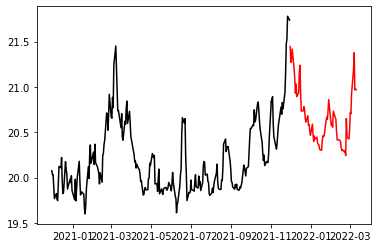

In [52]:

plt.plot(train["TC"], color = "black", label = "Real")
plt.plot(test["TC"], color = "black", label = "Real")
plt.plot(merge4["TC"], color = "red", label = 'Cont')

In [53]:
# Agrupación en mes
testM1 = merge4.resample('M').mean()
testM1

,TC,RI
Fecha,,
2021-11-30,21.445300,199993.000000
2021-12-31,20.891843,201828.804348
2022-01-31,20.497771,201897.890476
2022-02-28,20.449521,201512.115789
2022-03-31,20.928856,201687.100000


In [54]:
# Predicción 2022

yhat1 = res.forecast(steps=len(testM1.index))
yhat1.index = testM1.index
#yhat2["TC_Real_MAE"] = test[1:]["TC"]
yhat1["TC_Real_RMSE"] = testM1[0:]["TC"]
yhat1

,TC,RI,TC_Real_RMSE
Fecha,,,
2021-11-30,20.582730,196667.768583,21.445300
2021-12-31,20.567028,194174.190301,20.891843
2022-01-31,20.098570,193970.960296,20.497771
2022-02-28,20.019352,194661.701678,20.449521
2022-03-31,20.150650,195507.801702,20.928856


In [55]:
# DataFrame de datos reales y predichos

result = trainM
result1 = pd.concat([result, testM1], axis= 0)
result2 = pd.concat([result1, yhat1], axis= 1)
result2TC = result2["TC"]
result2TC.columns=["TC_Real", "TC_pred"]
result2TC

,TC_Real,TC_pred
Fecha,,
2020-11-30,20.075000,NaN
2020-12-31,19.956477,NaN
2021-01-31,19.925800,NaN
2021-02-28,20.314421,NaN
2021-03-31,20.759750,NaN
2021-04-30,20.020200,NaN
2021-05-31,19.963286,NaN
2021-06-30,20.016364,NaN
2021-07-31,19.958136,NaN


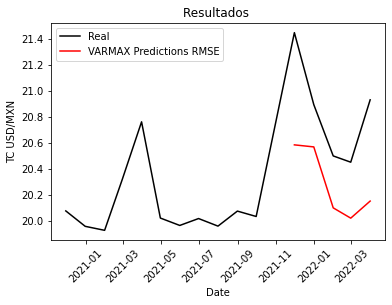

In [56]:
# Visualización de la prediccións

plt.plot(result2TC["TC_Real"], color = "black", label = "Real")
plt.plot(result2TC["TC_pred"], color = "red", label = 'VARMAX Predictions RMSE')

plt.ylabel('TC USD/MXN')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Resultados ")
plt.legend()
plt.show()